# Машинное обучение. ВМК МГУ
## Практическое задание 8: Градиентный бустинг деревьев

### Важно! О формате сдачи

* **Практически все выделенные задания из ноутбука оцениваются по системе <font color='red'>кросс-рецензирования</font>. Задания, в котором надо реализовать свой код и послать в систему, выделены здесь и в pdf отдельно**
* **В этом ноутбуке есть задание на ML-решение**
* **При решении ноутбука используйте данный шаблон. Не нужно удалять текстовые ячейки c разметкой частей ноутбука и формулировками заданий. Добавлять свои ячейки, при необходимости, конечно можно**
* **Везде, где в формулровке задания есть какой-либо вопрос (или просьба вывода), необходимо прописать ответ в ячейку (код или markdown).**
* **Наличие кода решения обязательно. Письменные ответы на вопросы без сопутствующего кода оцениваются в 0 баллов.**

**А также..**

Если в ячейке написана фраза "Вывод"/"Ответ на вопрос" итд, то ожидается ответ в виде текста (можете добавить ячейки с кодом, если считаете это необходимым, но это необязательно). Если в ячейке написано "Your code here", то ожидается ответ в виде кода (можете добавить ячейки с кодом, если считаете это необходимым, но это необязательно). Если есть и ячейка с фразой "Вывод", и ячейка с фразой "Your code here", то в ответе ожидается и код, и текст)

__В этом задании вы..:__

- Познакомитесь с несколькими новыми библиотеками машинного обучения
- Сравните между собой разные реализации градиентных бустингов
- Примените все полученные знания для получения лучшего скора на датасете фильмов

### *Примерное время выполнения (run all) всех ячеек ноутбука (без ML-решения): 60 минут*

----------------------------------------------

Немного магии, которую не надо менять, но надо выполнить перед каждым запуском!

## Установка в Google Colab
Если вы используете Google Colab, то вам достаточно установить библиотеки с помощью ячейки ниже.

После установки нужных версий нажмите на кнопку `Restart runtime`, которая появится в следующей ячейке после завершения ее выполнения.

После перезапуска (`Restart runtime`) устанавливать библиотеки еще раз не нужно, достаточно проверить, что установилась их новая версия.

**Важно!**
Устанавливать нужные версии нужно каждый раз, когда создается новый рантайм. Например, если вы 2 часа подряд делаете это задание, то подготовить библиотеки достаточно 1 раз. Но если вы, например, начали в понедельник, затем закрыли/выключили ноутбук, то при продолжении в среду, вам нужно будет запустить рантайм заново и следовательно заново установить библиотеки.

**Обратите внимание, что установка `torch` и `tensorflow` через `pip` может сломать ваше окружение, особенно если вы используете GPU. Выполняйте их установку в соответствии с Вашей конфигурацией системы или в отдельном виртуальном окружении**

Внимание! Ячейка перезапускает рантайм для учета обновления библиотек!

Тот же файл ссылкой: https://drive.google.com/file/d/1emagLwrQrZoaitHvoRkp2ZOFNg0TsZdR/view?usp=share_link

In [ ]:
!pip install --upgrade --no-cache-dir gdown
!gdown 1emagLwrQrZoaitHvoRkp2ZOFNg0TsZdR

!pip install -r /content/requirements2.txt

if 'google.colab' in str(get_ipython()):
    import IPython, ipywidgets, google

    button = ipywidgets.Button(
        description='Нажмите, чтобы перезапустить Google Colab Runtime',
        layout=ipywidgets.Layout(width='auto', height='40px')
    )
    button.on_click(lambda _: get_ipython().kernel.do_shutdown(True))
    IPython.display.display(button)

In [2]:
import matplotlib
assert(matplotlib.__version__ == '3.5.3')




## Введение

Привет, ребятушки!

Сегодня мы с вами будем решать очень важную задачу, а именно оценивать цену подержанных автомобилей в ряде стран. Делать мы это будем с помощью различных методов градиентного бустинга. Мы с вами узнаем, что в мире существует не только sklearn, и что существуют библиотеки, облегчающие нам задачу поиска оптимальных параметров для моделей.

**Внимание! Во всех заданиях в качестве целевой метрики используется MAE (средняя абсолютная ошибка).** Значение MAE вычисляется как

$$
  MAE = \sum_{i = 1}^N\dfrac{|a(x_i) - y_i|}{N},
$$

где $N$ - число объектов в тестовой выборке, $x_i$ - вектор признаков i-го объекта, $a(x_i)$ - предсказание на i-ом объекте, $y_i$ - значение целевого признака на i-м объекте.

## Используемые библиотеки

В этом задании нам понадобятся три бибиотеки, которыми вы ранее не пользовались в этом курсе, а именно:

**XGBoost**: Документация [здесь](https://xgboost.readthedocs.io/en/stable/).<br />
**LightGBM**: Документация [здесь](https://lightgbm.readthedocs.io/en/latest/index.html). Также дополнительно про установку [тут](https://pypi.org/project/lightgbm/).<br />
**Catboost**: Документация [здесь](https://catboost.ai/en/docs/). Можно найти также некоторую информацию на русском [тут](https://habr.com/ru/company/otus/blog/527554/).<br />
**HyperOpt**: Документация [здесь](http://hyperopt.github.io/hyperopt/). <br />

Внимание! Вникать и подробно читать документацию к каждой библиотеке нет необходимости! Достаточно обращаться туда для нахождения примеров обучения.


## Как правильно перебирать параметры

В этом ноутбуке мы будем несколько раз заниматься поиском оптимальных параметров для градиентного бустинга, перебирая задания по заданной сетке. В этом задании от Вас не будет требоваться найти самые лучшие параметры, но всё равно важно правильно составлять сетку для перебора. Для этого нужно понимать суть параметров и их смысл.



**learning_rate** -- темп обучения нашего метода. Для этого метода сетка перебора должна быть логарифмической, т.е. перебирать порядковые значения (к примеру, [1e-3, 1e-2, 1e-1, 1]). В большинстве случаев достаточно перебрать значения от 1e-5 до 1.<br />
**max_depth** -- максимальная глубина деревьев в ансамбле. Вообще говоря, эта величина зависит от числа признаков, но обычно лучше растить небольшие деревья. К примеру, библиотека CatBoost, которую мы будем исследовать сегодня, рекомендует перебирать значения до 10 (и уточняется, что обычно оптимальная глубина лежит от 6 до 10).<br />
**n_estimators** -- количество деревьев в ансамбле. Обычно стоит перебирать с каким-то крупным шагом (можно по логарифмической сетке). Здесь важно найти баланс между производительностью, временем обучения и качеством. Обычно нескольких тысяч деревьев бывает достаточно.<br />

Учтите, что в реальных задачах необходимо следить за тем, что оптимальные значения параметров не попадают на границы интервалов, т.е. что вы нашли хотя бы локальный минимум. Если Вы перебрали значения параметра от 1 до 10 и оказалось, что 10 - оптимальное значение, значит следует перебрать и бОльшие числа, чтобы убедиться, что качество не улучшается дальше (или по крайней мере убедиться, что рост качества сильно замедляется и на сильное улучшения рассчитывать не стоит.


## Подготовка датасета

Все библиотеки, используемые сегодня, мы будем проверять на одних и тех же параметрах: n_estimators=1000, max_depth=5, learning_rate=0.1. Таким образом мы устанавливаем, соответственно, число деревьев в ансамбле равным 1000, ограничиваем максимальную глубину деревьев 5 и устанавливаем темп обучения равным 0.1. Создадим сразу словарь, чтобы передавать эти параметры создаваемым регрессорам (если вдруг не знали, словарь можно передавать как параметры, поставив перед ним **).

Эти параметры мы вынесем в отдельную переменную `test_parameters`.

При желании можно почитать про этот датасет на платформе kaggle: [ссылка на данные](https://www.kaggle.com/bushnag/cars-in-the-middle-east?select=dataframe_YesIndex_YesHeader_C.csv). <span style="color:red"> <font color="red">Не скачивайте датасет из kaggle для выполнения ноутбука, поскольку его могут изменить.</font></span> Нас интересует файл dataframe_YesIndex_YesHeader_C.csv, поскольку он уже хорошо предобработан (хотя, конечно, датасаентисты должны сами уметь это делать, но ладно).
Давайте попробуем загрузить датасет в память и посмотреть, как он выглядит.

При работе в google colab для скачивания датасета достаточно запустить следующую ячейку.

При работе с ноутбуком <span style="color:red"> <font color="red">на локальном компьютере</font></span> Вы можете скачать файл по [этой ссылке](https://drive.google.com/file/d/1gdDv2kTCEkF3ia1vvbvRFJM0YfqmPplb/view?usp=sharing) и чуть ниже заменить ` /content/dataframe_YesIndex_YesHeader_C.csv` (в строке с `read_csv`) на ваш локальный путь до файла.

In [ ]:
# при локальном выполнении запускать эту ячейку НЕ НАДО
!gdown 1gdDv2kTCEkF3ia1vvbvRFJM0YfqmPplb

In [32]:
%matplotlib inline
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import mean_absolute_error, make_scorer

from hyperopt import hp, tpe, Trials, STATUS_OK
from hyperopt.fmin import fmin
from hyperopt.pyll import scope

from xgboost import XGBRegressor

from lightgbm import LGBMRegressor

from catboost import CatBoostRegressor

import matplotlib.pyplot as plt

import pandas as pd

import numpy as np

import time

In [5]:
test_parameters = {"n_estimators": 1000, "max_depth": 5, "learning_rate":0.1}

df = pd.read_csv('/content/dataframe_YesIndex_YesHeader_C.csv', index_col=0)
df.head()

,Engine Capacity,Cylinders,Drive Type,Fuel Tank Capacity,Fuel Economy,Fuel Type,Horsepower,Torque,Transmission,Top Speed,...,Acceleration,Length,Width,Height,Wheelbase,Trunk Capacity,name,price,currency,Country
0,1.2,3,0,42.0,4.9,0,76,100.0,0,170,...,14.0,4.245,1.670,1.515,2.550,450.0,Mitsubishi Attrage 2021 1.2 GLX (Base),34099.0,0,0
1,1.2,3,0,42.0,4.9,0,76,100.0,0,170,...,14.0,4.245,1.670,1.515,2.550,450.0,Mitsubishi Attrage 2021 1.2 GLX (Base),34099.0,0,0
2,1.4,4,0,45.0,6.3,0,75,118.0,1,156,...,16.0,3.864,1.716,1.721,2.513,2800.0,Fiat Fiorino 2021 1.4L Standard,41250.0,0,0
3,1.6,4,0,50.0,6.4,0,102,145.0,0,180,...,11.0,4.354,1.994,1.529,2.635,510.0,Renault Symbol 2021 1.6L PE,44930.0,0,0
4,1.5,4,0,48.0,5.8,0,112,150.0,0,170,...,10.9,4.314,1.809,1.624,2.585,448.0,MG ZS 2021 1.5L STD,57787.0,0,0


In [6]:
df.price.min(), df.price.max()

(2899.0, 10780000.0)

### Задание 0 (без проверки, 0 баллов)

Посмотрите на цены автомобилей. Попробуйте понять, написаны они в одной валюте или нет. Если нет -- будут ли у нас серьезные проблемы при использовании деревьев? Стоит ли нам что-то сделать для того, чтобы нивелировать эту проблему?


В глаза бросаются две проблемы: у нас имеется информация о производителе автомобиля, скрытая в текстовой переменной модели автомобиля (нет отдельного признака). Также имеются некоторые категориальные переменные. Со всем этим безобразием надо что-то сделать.

### **Задание 1 (кросс-проверка, 3 балла)**
**Данные**: датасет со стоимостью подержанных автомобилей  
**Цели**: В данном задании следует выполнить следующие пункты (выполнять можно в любом порядке)
1. Изучить датасет, проверить наличие пропусков. Под пропусками подразумевается значение N/A вместо признака. При необходимости заменить их на среднее значение признака.
3. Добавить столбец brand с информацией о производителе автомобиля (для простоты можно взять первое слово в названии модели)
4. Решить, какие признаки Вы хотите сделать категориальными. Конвертировать выбранные категориальные столбцы в тип category.
5. Создать датасет А с категориальными признаками в виде категорий. Для этого необходимо создать вектор целевых значений (столбец цен автомобилей) и матрицу признаков с категориальными переменными, в которых все категориальные переменные поставлены в тип category (получается путем удаления только целевой переменной из матрицы с данными). Дополнительно стоит создать список с названиями и индексами столбцов категориальных переменных (поможет в будущем).
6. Создать датасет B без категориальных признаков. Для этого необходимо создать вектор целевых значений (столбец цен автомобилей) и удалить из матрицы признаков столбец с целевыми переменными, а также все категориальные переменные.
8. Создать датасет C с категориальными признаками в виде one-hot encoding. Для этого необходимо создать вектор целевых значений (столбец цен автомобилей), удалить из матрицы признаков столбец с целевыми переменными и все категориальными переменные, а затем добавить новые признаки, соответствующие one-hot encoding категориальных переменных (здесь вам поможет функция `pd.get_dummies`).
9. Разбить датасеты на тренировочное и тестовое множества, используя `train_test_split(X, y, test_size=0.25, random_state=0)` (зафиксировав random_seed мы получим одинаковое разбиение на обучение/тест для всех трёх выборок).

In [7]:
# проверка наличия пропусков (пропусков нет)
assert df.isna().any().sum() == 0

# добавляем столбец brand
df["brand"] = df.name.apply(lambda x : x.split()[0].strip())

# сделать категориальными Cylinders, Drive Type, Fuel Type, Transmission,
# Seating Capacity, currency, Country, name, brand
columns_category = ["Cylinders", "Drive Type", "Fuel Type", "Transmission",
                     "Seating Capacity", "currency", "Country", "name", "brand"]
df[columns_category] = df[columns_category].astype("category")

# создаем датафрейм A
A = df.drop(columns="price")

# созлдаем датафрейм В
B = df.drop(columns=(columns_category + ["price"]))

# создаем датафрей С
C = pd.get_dummies(df, columns=columns_category).drop(columns=["price"])

# разбиваем датасеты
X_train_A, X_test_A, y_train_A, y_test_A = train_test_split(A, df.price,
                                                            test_size=0.25,
                                                            random_state=0)
X_train_B, X_test_B, y_train_B, y_test_B = train_test_split(B, df.price,
                                                            test_size=0.25,
                                                            random_state=0)
X_train_C, X_test_C, y_train_C, y_test_C = train_test_split(C, df.price,
                                                            test_size=0.25,
                                                            random_state=0)

Итак, кажется, что у нас всё готово для того, чтобы начать искать ответы на волнующие нас вопросы. Начнем со столь любимой нами библиотеки, а именно...

## Градиентный бустинг со sklearn

Естественно, в sklearn имеется реализация градиентного бустинга, которая хранится в sklearn.ensemble.GradientBoostingRegressor. Преимущественно данным классом пользуются в учебных заданиях, а в реальных задачах предпочтение отдаётся другим библиотекам. Давайте попробуем понять, заслуженно ли градиентный бустинг в sklearn не пользуется популярностью.

FYI: в sklearn имеется также реализация GradientBoostingClassifier для задач классификации, но пользоваться им мы сегодня не будем.

GradientBoostingRegressor из коробки не умеет работать с категориальными признаками. Мы к этому уже подготовились, закодировав наши признаки.

### **Задание 2 (кросс-проверка, 1 балл)**:

**Данные**: датасет со стоимостью подержанных автомобилей    
**Метрика**: MAE    
**Цели**: В данном задании следует выполнить следующие пункты:    
1. Обучить sklearn.ensemble.GradientBoostingRegressor на датасетах B и C (получится два разных регрессора), используя параметры n_estimators=1000, max_depth=5, learning_rate=0.1 (наши `test_parameters`). Замерить время обучения.
2. Посчитать MAE для предсказаний на соответствующих тренировочном и тестовом множествах (можно воспользоваться sklearn.metrics.mean_absolute_error). Замерить время предсказания.
3. Вывести в таблице DataFrame результаты о времени обучения, времени предсказания, MAE на тренировочном и тестовом множествах.
4. Сделайте выводы. Оцените полезность категориальных переменных. Оцените время, затраченное на обучение. Попробуйте дать оценку получившемуся MAE: оно большое или маленькое?


In [8]:
GBR_B = GradientBoostingRegressor(**test_parameters)
GBR_C = GradientBoostingRegressor(**test_parameters)

In [9]:
start_time = time.time()
GBR_B.fit(X_train_B, y_train_B)
B_fit_time_GBR = np.round(time.time() - start_time)

start_time = time.time()
GBR_C.fit(X_train_C, y_train_C)
C_fit_time_GBR = np.round(time.time() - start_time)

In [10]:
start_time = time.time()
predict_B = GBR_B.predict(X_test_B)
B_predict_time_GBR = np.round(time.time() - start_time, 2)

start_time = time.time()
predict_C = GBR_C.predict(X_test_C)
C_predict_time_GBR = np.round(time.time() - start_time, 2)

B_MAE_test_GBR = np.round(mean_absolute_error(y_test_B, predict_B))
C_MAE_test_GBR = np.round(mean_absolute_error(y_test_C, predict_C))

predict_B = GBR_B.predict(X_train_B)
predict_C = GBR_C.predict(X_train_C)
B_MAE_train_GBR = np.round(mean_absolute_error(y_train_B, predict_B))
C_MAE_train_GBR = np.round(mean_absolute_error(y_train_C, predict_C))

In [11]:
row1_GBR = ["sklearn", "B", B_fit_time_GBR, B_predict_time_GBR, B_MAE_train_GBR, B_MAE_test_GBR]
row2_GBR = ["sklearn", "C", C_fit_time_GBR, C_predict_time_GBR, C_MAE_train_GBR, C_MAE_test_GBR]
columns=['Method', 'Dataset', 'Training time', 'Prediction time', 'Train MAE', 'Test MAE']
df_skl = pd.DataFrame([row1_GBR, row2_GBR], columns=columns)
df_skl

,Method,Dataset,Training time,Prediction time,Train MAE,Test MAE
0,sklearn,B,22.0,0.12,92000.0,123459.0
1,sklearn,C,194.0,0.53,8613.0,21793.0


**Ваши выводы:**

* Категориальные переменные полезны, по ним модель лучше понимает закономерности в данных
* `МАЕ` на `С` лучше, так как цена автомобиля измерятся в основном в сотнях тысяч, на первом датасете `МАЕ` очень большое
* `OneHotEncoding` дало существенную прибавку качества


И так, sklearn предлагает нам привычный и простой способ тренировки моделей. Однако, для градиентного бустинга существует множество эвристик и трюков, помогающих улучшить результаты. И одна из библиотек, реализующая улучшенную версию бустинга, называется xgboost.

## Градиентный бустинг с XGBoost

XGBoost стала достаточно популярной библиотекой, которая позволяет добиться хороших результатов без особых усилий (во всяком случае, так гласят легенды). И у нас для вас две новости: хорошая и плохая. Хорошая – xgboost, хоть и является сторонней библиотекой, сохраняет интерфейс sklearn. Плохая – она тоже не умеет из коробки работать с категориальными признаками. Ну что же, давайте пощупаем это безобразие. На этот раз нас интересует класс xgboost.XGBRegressor.

Daily Fact: на самом деле в xgboost есть экспериментальная поддержка категориальных переменных, которая еще не добавлена в стабильную версию, поэтому ею мы пользоваться не будем.

### Задание 3 (кросс-проверка, 1 балл):
**Данные**: датасет со стоимостью подержанных автомобилей  
**Метрика**: MAE  
**Цели**: В данном задании следует выполнить следующие пункты:  
1. Обучить xgboost.XGBRegressor на датасетах B и C, используя параметры n_estimators=1000, max_depth=5, learning_rate=0.1 (наши `test_parameters`). Замерить время обучения.
2. Посчитать MAE для полученных предсказаний на соответствующих тренировочном и тестовом множествах (можно воспользоваться sklearn.metrics.mean_absolute_error). Замерить время предсказания
3. Вывести в таблице DataFrame результаты о времени обучения, времени предсказания, MAE на тренировочном и тестовом множествах.
4. Сделайте выводы. Оцените время, затраченное на обучение, сравните с sklearn.


In [13]:
XGB_B = XGBRegressor(**test_parameters)
XGB_C = XGBRegressor(**test_parameters)

start_time = time.time()
XGB_B.fit(X_train_B, y_train_B)
B_fit_time_XGB = np.round(time.time() - start_time)

start_time = time.time()
XGB_C.fit(X_train_C, y_train_C)
C_fit_time_XGB = np.round(time.time() - start_time)

start_time = time.time()
predict_B = XGB_B.predict(X_test_B)
B_predict_time_XGB = np.round(time.time() - start_time, 2)

start_time = time.time()
predict_C = XGB_C.predict(X_test_C)
C_predict_time_XGB = np.round(time.time() - start_time, 2)

B_MAE_test_XGB = np.round(mean_absolute_error(y_test_B, predict_B))
C_MAE_test_XGB = np.round(mean_absolute_error(y_test_C, predict_C))

predict_B = XGB_B.predict(X_train_B)
predict_C = XGB_C.predict(X_train_C)
B_MAE_train_XGB = np.round(mean_absolute_error(y_train_B, predict_B))
C_MAE_train_XGB = np.round(mean_absolute_error(y_train_C, predict_C))

In [15]:
row1_XGB = ["XGBoost", "B", B_fit_time_XGB, B_predict_time_XGB, B_MAE_train_XGB, B_MAE_test_XGB]
row2_XGB = ["XGBoost", "C", C_fit_time_XGB, C_predict_time_XGB, C_MAE_train_XGB, C_MAE_test_XGB]
columns=['Method', 'Dataset', 'Training time', 'Prediction time', 'Train MAE', 'Test MAE']
df_xgb = pd.DataFrame([row1_XGB, row2_XGB], columns=columns)
df_xgb

,Method,Dataset,Training time,Prediction time,Train MAE,Test MAE
0,XGBoost,B,13.0,0.10,92415.0,123037.0
1,XGBoost,C,360.0,0.26,10799.0,22433.0


**Ваши выводы:**

*  Опять видим, что `OneHotEncoding` сильно уличшил показатели. На датасете `В` посчитали с большой ошибкой, но зато быстро)
*  Время почти не изменилось по сравнению с `sklearn`, но стало чуть больше.
*  Ошибка на тесте чуть уменьшилась для датасета `С`


Таким вот несложным образом нам удалось воспользоваться еще одной библиотекой. Давайте перейдем к третьей библиотеке, которую мы сегодня изучим, и называется она lightgbm.

## Градиентный бустинг в lightgbm

Про Lightgbm легенды гласят, что она очень быстрая и легкая: что самый большой датасет она без проблем переварит за относительно небольшое время. А еще её разрабатывали не хухры кто, а сами мелкомягкие, так что попробовать её определённо стоит. На этот раз у нас вновь две новости, две хороших и две плохих. Первая хорошая — lightgbm тоже похож на sklearn. Вторая хорошая — lightgbm умеет из коробки работать с категориальными признаками! Плохая — делает она это немного нетривиально (не зря я просил вас запомнить категориальные переменные!). Вторая плохая — да, нам придётся этим пользоваться для выполнения задания.

Внимание! LightGBM может писать сотню радостных сообщений о том, что он увидел ваши categorical_feature и использует их. При желании можете заглушать эти оповещения, ибо в случае перебора параметров их становится слишком много. (заклинание для заглушения: `warnings.filterwarnings("ignore")`)

### Задание 4 (кросс-проверка, 2 балла):
**Данные**: датасет со стоимостью подержанных автомобилей  
**Метрика**: MAE  
**Цели**: В данном задании следует выполнить следующие пункты:  
1. В случае датасета, сохраненном в numpy, lightgbm требует, чтобы категории были закодированы целыми числами от 0 до числа признаков(e.g. ['a', 'b', 'a'] -> [0, 1, 0]). Сделайте это для датасета A. Если вы используете pandas, то для датасета A достаточно установить соответствующие столбцы типа "категория", тогда categorical_feature='auto' сам всё подхватит.
2. Обучить lightgbm.LGBMRegressor на датасетах A, B и C, используя параметры n_estimators=1000, max_depth=5, learning_rate=0.1. В случае датасета A, передайте в функцию fit индексы/имена категориальных признаков. Замерить время обучения.
4. Посчитать MAE для полученных предсказаний на соответствующих тренировочном и тестовом множествах (можно воспользоваться sklearn.metrics.mean_absolute_error). Сделайте выводы о полезности использования категориальных переменных и времени обучения.
5. Вывести результаты и время в таблице DataFrame.

In [16]:
import warnings
warnings.filterwarnings("ignore")

LGBM_A = LGBMRegressor(**test_parameters)
LGBM_B = LGBMRegressor(**test_parameters)
LGBM_C = LGBMRegressor(**test_parameters)

# A train
start_time = time.time()
LGBM_A.fit(X_train_A, y_train_A, categorical_feature=columns_category)
A_fit_time_LGBM = np.round(time.time() - start_time)

# B train
start_time = time.time()
LGBM_B.fit(X_train_B, y_train_B)
B_fit_time_LGBM = np.round(time.time() - start_time)

# C train
start_time = time.time()
LGBM_C.fit(X_train_C, y_train_C)
C_fit_time_LGBM = np.round(time.time() - start_time)

# A test
start_time = time.time()
predict_A = LGBM_A.predict(X_test_A)
A_predict_time_LGBM = np.round(time.time() - start_time, 2)

# B test
start_time = time.time()
predict_B = LGBM_B.predict(X_test_B)
B_predict_time_LGBM = np.round(time.time() - start_time, 2)

# C test
start_time = time.time()
predict_C = LGBM_C.predict(X_test_C)
C_predict_time_LGBM = np.round(time.time() - start_time, 2)

# MAE test
A_MAE_test_LGBM = np.round(mean_absolute_error(y_test_A, predict_A))
B_MAE_test_LGBM = np.round(mean_absolute_error(y_test_B, predict_B))
C_MAE_test_LGBM = np.round(mean_absolute_error(y_test_C, predict_C))

predict_A = LGBM_A.predict(X_train_A)
predict_B = LGBM_B.predict(X_train_B)
predict_C = LGBM_C.predict(X_train_C)

# MAE train
A_MAE_train_LGBM = np.round(mean_absolute_error(y_train_A, predict_A))
B_MAE_train_LGBM = np.round(mean_absolute_error(y_train_B, predict_B))
C_MAE_train_LGBM = np.round(mean_absolute_error(y_train_C, predict_C))

In [17]:
row0_LGBM = ["lightgbm", "A", A_fit_time_LGBM, A_predict_time_LGBM, A_MAE_train_LGBM, A_MAE_test_LGBM]
row1_LGBM = ["lightgbm", "B", B_fit_time_LGBM, B_predict_time_LGBM, B_MAE_train_LGBM, B_MAE_test_LGBM]
row2_LGBM = ["lightgbm", "C", C_fit_time_LGBM, C_predict_time_LGBM, C_MAE_train_LGBM, C_MAE_test_LGBM]
columns=['Method', 'Dataset', 'Training time', 'Prediction time', 'Train MAE', 'Test MAE']
df_lightgbm = pd.DataFrame([row0_LGBM, row1_LGBM, row2_LGBM], columns=columns)
df_lightgbm

,Method,Dataset,Training time,Prediction time,Train MAE,Test MAE
0,lightgbm,A,8.0,0.07,16542.0,25297.0
1,lightgbm,B,0.0,0.05,97470.0,122341.0
2,lightgbm,C,1.0,0.09,20791.0,31303.0


**Ваши выводы:**

* Видим, что время работы на порядок быстрее
* Лучше всего справился датасет `А`, видимо, потому что LGBMRegressor как-то по-своему кодирует признаки
* При этом видим, что на датасете `В` ошибка даже больше чем у прошлых регрессоров



Как вы видите, иногда можно не возиться с OHE, а позволить библиотекам самим это сделать (хотя иногда при этом приходится повозиться с самими данными, чтобы библиотека их съела).

Итак, мы с вами почти стали мастерами градиентного бустинга. Переходим к последней звезде нашего хит-парада.


## Градиентный бустинг в catboost

_**Пролог:** Why does catboost need random seed? It grows random trees!_

Библиотека, созданная в тёмных подвалах Яндекса. По легендам эта библиотека умеет работать с категориальными данными, быстрая, эффективная, легко настраивается, из коробки понимает текстовые признаки в задачах классификации и спасла Брюса Уиллиса. Давайте проверим. В качестве регрессора нас интересует catboost.CatBoostRegressor.

**Внимание!** Эта библиотека еще более болтлива, чем lightgbm, но это (почти) полностью лечится с помощью verbose. Однако ноутбуки всё равно неприлично разрастаются в размерах, поэтому просим вас сделать следующее: <span style="color:red"> обучать catboost в первой ячейке и очистить её вывод перед сдачей! </span> Все необходимые выводы стоит делать во второй ячейке.

А еще эта библиотека может неожиданно создать вам парочку новых папок...

### Задание 5 (кросс-проверка, 2 балла):
**Данные**: датасет со стоимостью подержанных автомобилей  
**Метрика**: MAE  
**Цели**: В данном задании следует выполнить следующие пункты:  
1. Обучить catboost.CatBoostRegressor на датасетах A, B и C, используя параметры используя параметры n_estimators=1000, max_depth=5, learning_rate=0.1, verbose=False.
1. В случае датасета A, передайте на вход методу fit/конструктору параметр cat_features, содержащий имена/индексы категориальных переменных. В данном случае переводить категории в целые числа, как мы делали для lightgbm, не нужно. Замерьте время обучения.
3. Посчитать MAE для полученных предсказаний на соответствующих тренировочном и тестовом множествах (можно воспользоваться sklearn.metrics.mean_absolute_error).
4. Сделайте выводы и полезности использования категориальных переменных и времени обучения.
5. Вывести результаты и время в таблице DataFrame.


In [18]:
import warnings
warnings.filterwarnings("ignore")

CatBoost_A = CatBoostRegressor(n_estimators=1000, max_depth=5, learning_rate=0.1, verbose=False)
CatBoost_B = CatBoostRegressor(n_estimators=1000, max_depth=5, learning_rate=0.1, verbose=False)
CatBoost_C = CatBoostRegressor(n_estimators=1000, max_depth=5, learning_rate=0.1, verbose=False)

In [19]:
# A train
start_time = time.time()
CatBoost_A.fit(X_train_A, y_train_A, cat_features=columns_category)
A_fit_time_CatBoost = np.round(time.time() - start_time)

# B train
start_time = time.time()
CatBoost_B.fit(X_train_B, y_train_B)
B_fit_time_CatBoost = np.round(time.time() - start_time)

# C train
start_time = time.time()
CatBoost_C.fit(X_train_C, y_train_C)
C_fit_time_CatBoost = np.round(time.time() - start_time)

# A test
start_time = time.time()
predict_A = CatBoost_A.predict(X_test_A)
A_predict_time_CatBoost = np.round(time.time() - start_time, 2)

# B test
start_time = time.time()
predict_B = CatBoost_B.predict(X_test_B)
B_predict_time_CatBoost = np.round(time.time() - start_time, 2)

# C test
start_time = time.time()
predict_C = CatBoost_C.predict(X_test_C)
C_predict_time_CatBoost = np.round(time.time() - start_time, 2)

# MAE test
A_MAE_test_CatBoost = np.round(mean_absolute_error(y_test_A, predict_A))
B_MAE_test_CatBoost = np.round(mean_absolute_error(y_test_B, predict_B))
C_MAE_test_CatBoost = np.round(mean_absolute_error(y_test_C, predict_C))

predict_A = CatBoost_A.predict(X_train_A)
predict_B = CatBoost_B.predict(X_train_B)
predict_C = CatBoost_C.predict(X_train_C)

# MAE train
A_MAE_train_CatBoost = np.round(mean_absolute_error(y_train_A, predict_A))
B_MAE_train_CatBoost = np.round(mean_absolute_error(y_train_B, predict_B))
C_MAE_train_CatBoost = np.round(mean_absolute_error(y_train_C, predict_C))

In [20]:
row0_CatBoost = ["catboost", "A", A_fit_time_CatBoost, A_predict_time_CatBoost, A_MAE_train_CatBoost, A_MAE_test_CatBoost]
row1_CatBoost = ["catboost", "B", B_fit_time_CatBoost, B_predict_time_CatBoost, B_MAE_train_CatBoost, B_MAE_test_CatBoost]
row2_CatBoost = ["catboost", "C", C_fit_time_CatBoost, C_predict_time_CatBoost, C_MAE_train_CatBoost, C_MAE_test_CatBoost]
columns=["Method", 'Dataset', 'Training time', 'Prediction time', 'Train MAE', 'Test MAE']
df_catboost = pd.DataFrame([row0_CatBoost, row1_CatBoost, row2_CatBoost], columns=columns)
df_catboost

,Method,Dataset,Training time,Prediction time,Train MAE,Test MAE
0,catboost,A,11.0,0.05,12005.0,15613.0
1,catboost,B,9.0,0.01,99395.0,121639.0
2,catboost,C,8.0,0.10,15592.0,22836.0


**Ваши выводы:**

* Время обучения примерно такое же как и у `XGBRegressor` и `GradientBoostingRegressor`. При этом эта библиотека показала лучший результат на датасете `A`.

И так, мы наконец познакомились со всеми библиотеками градиентного бустинга.

## Обобщение результатов

На текущем этапе у вас должно быть несколько датафреймов результатами по каждой библиотеке. Мы, конечно, сделали некоторые выводы, но пришло время собрать это в красивый отчет.

### Задание 6 (кросс-проверка, 2 балла):
**Данные**: датасет с ценами подержанных автомобилей  
**Цели**: В данном задании следует выполнить следующие пункты:  
1. При помощи одного или нескольких графиков показать результаты различных библиотек: времени работы и качество результатов. Можете воспользоваться любым типом графиков: гистограммы, scatter и т.д. По этим графикам должно быть понятно какая библиотека и насколько быстрее, насколько различается их качество.
2. По графикам сравните библиотеки, производительность и качество работы. Опишите ваши выводы ниже.

In [21]:
import seaborn as sns

In [22]:
%matplotlib inline
plt.style.use("ggplot")
plt.rcParams['figure.dpi'] = 100

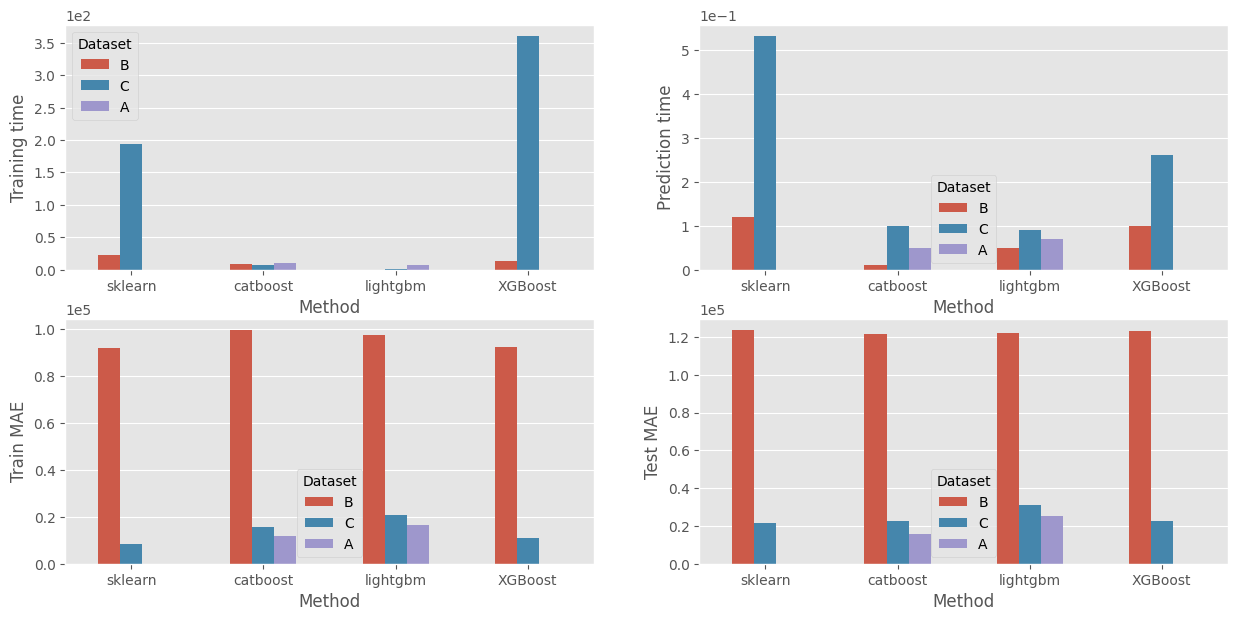

In [23]:
result = pd.concat([df_skl, df_catboost, df_lightgbm, df_xgb])

fig, axes = plt.subplots(2, 2, figsize=(15, 7))

sns.barplot(data=result, x="Method", y="Training time", hue="Dataset", ax = axes[0, 0], width= 0.5)
sns.barplot(data=result, x="Method", y="Prediction time", hue="Dataset", ax = axes[0, 1], width= 0.5)
sns.barplot(data=result, x="Method", y="Train MAE", hue="Dataset", ax = axes[1, 0], width= 0.5)
sns.barplot(data=result, x="Method", y="Test MAE", hue="Dataset", ax = axes[1, 1], width= 0.5)
axes[0, 0].ticklabel_format(style='sci', axis='y', scilimits=(0,0))
axes[0, 1].ticklabel_format(style='sci', axis='y', scilimits=(0,0))
axes[1, 0].ticklabel_format(style='sci', axis='y', scilimits=(0,0))
axes[1, 1].ticklabel_format(style='sci', axis='y', scilimits=(0,0))

**Ваши выводы:**

* Производительность
   * Быстрее всех обучался lightbm, вторым по скорости стал catboost
   * Дольше всех работал XGBoost
* Качетво
   * Самую маленькую МАЕ на тесте показал catboost
   * Худшее качетсво получилось на датасете B, а лучшее на датасете А



## Оптимизация параметров

И так, мы с вами научились пользоваться библиотеками для градиентного бустинга. Пришло время заняться самой интересной (нет) частью исследований, а именно подбором параметров!

Выберите любые две библиотеки из тех, с которыми мы работали в этом ноутбуке, и осуществите для них перебор параметров по сетке.

Обратите внимание, что:

1. Для всех библиотек вы можете воспользоваться классом GridSearchCV, реализованном в sklearn, осуществляющего кросс-валидацию всех параметров и поиска модели с лучшим качеством. Обратите внимание, что этот класс позволяет установить количество разбиений датасета, что достаточно сильно влияет на время работы. Также вы можете воспользоваться n_jobs=-1 для распараллеливания процесса перебора. ВНИМАНИЕ! Если Вы устанавливаете n_jobs для GridSearchCV, то не надо использовать этот параметр для обучаемых регрессоров! Результат может быть плачевным в плане времени...
2. В catboost существует своя реализация перебора параметров, которым можно также воспользоваться (речь о grid_search).
3. Для подбора правильной сетки параметров советуем обратиться к краткому руководству в начале ноутбука.


### Задание 7.1 (кросс-проверка, 2 балла):
**Данные**: датасет со стоимостью подержанных автомобилей  
**Метрика**: MAE  
**Цели**: В данном задании следует выполнить следующие пункты:  
1. Взять две любые библиотеки градиентного бустинга (можете взять самые быстрые)
2. Составить сетку перебора параметров, включающую параметры n_estimators, max_depth и learning_rate.
3. Осуществите перебор параметров по вашей сетке при помощи GridSearchCV на датасетах B и C. Замерьте время перебора. Посчитайте качество модели обученной с оптимальными (с позиции кросс-валидации) параметрами на тренировочном и тестовом множествах.
4. Сделайте выводы о полезности перебора параметров.


## Внимание!

По какой-то причине, которую мне не удалось выяснить, catboost в google colab работает очень медленно при переборе параметров. Если в соответствующем задании время обучения catboost занимает не многим более 10 секунд, то в случае кросс-валидации оно возрастает до 5 минут (соответственно, 5 минут в каждом из узлов). Поэтому используйте catboost на свой страх и риск :)

In [24]:
# определение параметров для перебора
parameters  = {'max_depth'         : [4, 5, 6,7,8],
              'learning_rate' : [1e-3, 1e-2, 1e-1, 1],
              'n_estimators'    : [500, 1000, 2000]
              }

LGBM_B = LGBMRegressor()
LGBM_C = LGBMRegressor()

clf_B = GridSearchCV(estimator=LGBM_B,
                     param_grid = parameters,
                     cv = 3,
                     n_jobs=-1,
                     verbose=1
                     )

clf_C = GridSearchCV(estimator=LGBM_C,
                     param_grid = parameters,
                     cv = 3,
                     n_jobs=-1,
                     verbose=1
                     )

# B train
start_time = time.time()
clf_B.fit(X_train_B, y_train_B)
B_fit_time_LGBM = np.round(time.time() - start_time)

# C train
start_time = time.time()
clf_C.fit(X_train_C, y_train_C)
C_fit_time_LGBM = np.round(time.time() - start_time)

Fitting 3 folds for each of 60 candidates, totalling 180 fits
Fitting 3 folds for each of 60 candidates, totalling 180 fits


In [25]:
clf_C.best_params_, clf_B.best_params_

({'learning_rate': 0.01, 'max_depth': 6, 'n_estimators': 500},
 {'learning_rate': 0.001, 'max_depth': 4, 'n_estimators': 2000})

In [26]:
model_B = LGBMRegressor(**clf_B.best_params_)
model_C = LGBMRegressor(**clf_C.best_params_)
cv_score_B = cross_val_score(model_B, X_test_B, y_test_B, cv=5, scoring='neg_mean_absolute_error').mean()
cv_score_C = cross_val_score(model_C, X_test_C, y_test_C, cv=5, scoring='neg_mean_absolute_error').mean()
print("model_B: {}, model_C: {}".format(np.round(cv_score_B, 2), np.round(cv_score_C, 2)))

model_B: -124774.17, model_C: -45806.59


In [27]:
# определение параметров для перебора
parameters  = {'max_depth'         : [9, 10],
               'learning_rate' : [0.01, 0.1, 1],
               'n_estimators'    : [1000, 1500, 2000],
               'verbose' : [False]
              }

CatBoost_B = CatBoostRegressor()
CatBoost_C = CatBoostRegressor()

clf_B = GridSearchCV(estimator=CatBoost_B,
                     param_grid = parameters,
                     cv = 2,
                     n_jobs=-1,
                     verbose=1
                     )

clf_C = GridSearchCV(estimator=CatBoost_C,
                     param_grid = parameters,
                     cv = 2,
                     n_jobs=-1,
                     verbose=1
                     )

# B train
start_time = time.time()
clf_B.fit(X_train_B, y_train_B)
end_time_B_CatBoost = np.round(time.time() - start_time)

# C train
start_time = time.time()
clf_C.fit(X_train_C, y_train_C)
end_time_B_CatBoost = np.round(time.time() - start_time)

Fitting 2 folds for each of 18 candidates, totalling 36 fits
Fitting 2 folds for each of 18 candidates, totalling 36 fits


In [28]:
clf_C.best_params_, clf_B.best_params_

({'learning_rate': 0.1,
  'max_depth': 9,
  'n_estimators': 2000,
  'verbose': False},
 {'learning_rate': 0.01,
  'max_depth': 9,
  'n_estimators': 1000,
  'verbose': False})

In [29]:
model_B = CatBoostRegressor(**clf_B.best_params_)
model_C = CatBoostRegressor(**clf_C.best_params_)
cv_score_B = cross_val_score(model_B, X_test_B, y_test_B, cv=5, scoring='neg_mean_absolute_error').mean()
cv_score_C = cross_val_score(model_C, X_test_C, y_test_C, cv=5, scoring='neg_mean_absolute_error').mean()
print("model_B: {}, model_C: {}".format(np.round(cv_score_B, 2), np.round(cv_score_C, 2)))

model_B: -125260.62, model_C: -30852.88


**Ваши выводы:**

* Перебор параметров позволяет лучше обучить модель под данные
* `Сatboost` плохо работает на кросс-валидации


### Задание 7.2 (бонус) (кросс-проверка, 4 балла):
**Данные**: датасет со стоимостью подержанных автомобилей  
**Метрика**: MAE  
**Цели**: В данном задании следует выполнить следующие пункты:  
1. Выполнить задание 7.1 с использованием всех библиотек (для каждой библиотеки можно использовать свою сетку перебора). Разрешается использовать маленькие сетки с небольшим числом узлов, но не менее 10.
1. Вывести ниже результаты работы с нашими дефолтными параметрами, а также с оптимальными.
1. Вы будете получать 1 балл за каждую библиотеку с использованием которой точность ваших оптимальных параметров превзойдет качество наших дефолтных параметров. Таким образом, максимальный балл за задание равен числу библиотек, 4 балла.


###Задание 8 (кросс-проверка, 2 балла):

**Данные**: датасет со стоимостью поддержанных автомобилей

**Метрика:** MAE

**Цели**: В данном задании следует выполнить следующие пункты:

 1.   Взять любую библиотеку градиентного бустинга (можете взять самую быструю)
 2.   Составить сетку перебора в hyperopt, включающую параметры n_estimators, max_depth и learning_rate в hyperopt. Вам могут понадобиться такие типы данных, как hp.choise, hp.qloguniform, hp.uniform и hp.quniform (можно также пользоваться np.arange). Также для округления значения типа float до целых чисел (4.0 -> 4) используйте scope.int.
 3.   Реализуйте функцию, которая принимает на вход словарь параметров для регрессора, и при помощи cv оценивает его качество на датасете A (можно воспользоваться cross_val_score, а для ускорения поставить cv=3). Не забудьте о том, в каком виде lightgbm принимает категориальные признаки в numpy и что также надо передавать индексы категориальных признаков.
 4.   Создайте объект trials=Trials(), который будет хранить информацию о процессе оптимизации.
 5.   Используя функцию fmin, оптимизируйте Вашу функцию. Установите algo=tpe.suggest, trials=trials и max_evals, по крайней мере, 50. verbose=1 позволит видеть прогресс-бар по типу tqdm.
 6.   Выведите получившиеся параметры. Нарисуйте график, показывающий значение loss в ходе оптимизации. Посчитайте качество на тесте при использовании лучших параметров (возвращаются после использования fmin). Сделайте выводы по результату.


In [33]:
space = {'n_estimators': scope.int(hp.quniform('n_estimators', 3000, 7000, 500)),
         'max_depth': scope.int(hp.quniform('max_depth', 5, 10, 1)),
         'learning_rate':  hp.loguniform('learning_rate', np.log(0.00001), np.log(1))
         }

def objective(params):
    model = LGBMRegressor(**params)

    cv_score = cross_val_score(model,
                               X_train_A,
                               y_train_A,
                               cv=3,
                               scoring='neg_mean_absolute_error',
                               fit_params={"categorical_feature":columns_category}).mean()

    return {'loss': -1*cv_score, 'params': params, 'status': STATUS_OK}

# информация о процессе оптимизации
trials = Trials()

# алгоритм оптимизации ищем вручную
tpe_algo = tpe.suggest

best_params = fmin(fn=objective,
                   space=space,
                   algo=tpe_algo,
                   max_evals=50,
                   trials=trials,
                   verbose=1)

100%|██████████| 50/50 [32:51<00:00, 39.43s/trial, best loss: 30622.323120082612]


In [34]:
best_params

{'learning_rate': 0.0037251458382494317,
 'max_depth': 10.0,
 'n_estimators': 7000.0}

In [35]:
cl = LGBMRegressor(**{'learning_rate': 0.0042, 'max_depth': 10, 'n_estimators': 7000})
cl.fit(X_train_A, y_train_A, categorical_feature=columns_category)
print("score: {}".format(np.round(mean_absolute_error(y_test_A, cl.predict(X_test_A)),2)))

score: 20011.81


**Ваши выводы:**

* Перебор параметров дал бльшой прирость в производительности. Удалось улучшить результат, который был на test_parameters

* Для `LGBMRegressor`:
 * `learning_rate`: 0.0042
  *`max_depth`: 10
  *`n_estimators`: 7000


## Предсказание зрительских симпатий

Ну что, детишки, а теперь перейдём к действительно важным вопросам.

**Внимание!** Следующее задание сдается в системе cv-gml.ru, задание `Град. бустинг (ML)` Для выполнения этого задания необходимо скачать датасет из задания. Здесь вы можете немного почитать про датасет и, при желании, поэкспериментировать. На cv-gml.ru загружайте уже готовый скрипт с подобранными параметрами для обучаемого регрессора. Релизовать код необходимо в шаблонном файле awards_prediction.py, который вы можете найти в проверяющей системе.

В некотором царстве, некотором государстве была развита кинопромышленность. Новые фильмы в этом государстве показывают по интернету, а пользователи после просмотра могут дать фильму некоторую "награду". Наша цель - предсказать число наград для фильма.

В нашем распоряжении имеются следующие данные:

**awards** - количество наград, полученных фильмом от пользователей (целевое значение)  
**potions** - количество магических зелий, потраченных на создание спец-эффектов  
**genres** - жанры созданного фильма  
**questions** - количество вопросов, заданных пользователями на соответствующих форумах об этом фильме до премьеры  
**directors** - режиссеры фильма (если неизвестны, то unknown)  
**filming_locations** - области, в которых снимался фильм  
**runtime** - продолжительность фильма в некоторых единицах, принятых в этом государстве  
**critics_liked** - количество критиков из 100, присудивших награды фильму на предварительных закрытых показах  
**pre-orders** - количество зрителей, заранее купивших билеты на первый показ  
**keywords** - ключевые слова, описывающие содержание фильма
**release_year** - год, во котором фильм был показан (конечно, в летоисчислении этого государства)

Следующие поля появляются несколько раз с разными значениями i:

**actor_i_known_movies** - количество известных фильмов актера i (i от 0 до 2)

**actor_i_postogramm** - количество подписчиков в социальной сети "по сто грамм" актера i (i от 0 до 2)

**actor_i_gender** - пол актера i (i от 0 до 2)

**actor_i_age** - возраст актера i (i от 0 до 2)

-----
**Внимание!** Учтите, что при OHE кодировании признаки на обучении и тестировании должны совпадать! Если вы примените простое .get_dummies() или что-то подобное, то признаки на трейне и тесте получатся разные! Так что вам, вероятно, придётся придумать способ для того, чтобы сохранить их :)  

Подсказка: для работы с текстом можно воспользоваться методом TF-IDF (ключевые слова: TfIdfTransformer). Также может быть полезен CountVectorizer. Только учтите, что никто не гарантирует улучшение результата с использованием данных методов  ;)

<font color="red">Внимание!</font> В проверяющей системе имеется проблема с catboost. При использовании этой библиотеки, в скрипте с решением необходимо инициализировать метод с использованием `train_dir` как показано тут:
`CatBoostRegressor(train_dir='/tmp/catboost_info')`

### Задание 9 (ML задание, 15 баллов):
**Данные**: датасет с наградами за фильмы

**Метрика**: MAE  

**Цели**: В данном задании следует выполнить следующие пункты:  
1. Взять любую библиотеку градиентного бустинга
2. Используя предложенный датасет, обучить регрессор для предсказания awards (предоставляем полную свободу в настройках и выборе методов)
3. Загрузить решение и получить качество на закрытой выборке больше порогового значения



`awards` - количество наград, полученных фильмом от пользователей (целевое значение)

`potions` - количество магических зелий, потраченных на создание спец-эффектов

`genres` - жанры созданного фильма

`questions` - количество вопросов, заданных пользователями на соответствующих форумах об этом фильме до премьеры

`directors` - режиссеры фильма (если неизвестны, то unknown)

`filming_locations` - области, в которых снимался фильм

`runtime` - продолжительность фильма в некоторых единицах, принятых в этом государстве

`critics_liked` - количество критиков из 100, присудивших награды фильму на предварительных закрытых показах

`pre-orders` - количество зрителей, заранее купивших билеты на первый показ

`keywords` - ключевые слова, описывающие содержание фильма

`release_year` - год, во котором фильм был показан (конечно, в летоисчислении этого государства) Следующие поля появляеются несколько раз с разными значениями i:

`actor_i_known_movies` - количество известных фильмов актера i (i от 1 до 3)

`actor_i_postogramm` - количество подписчиков в социальной сети "по сто грамм"актера i (i от 1 до 3)

`actor_i_gender` - количество пол актера i (i от 1 до 3)

`actor_i_age` - возраст актера i (i от 1 до 3)


In [36]:
import pandas as pd
import warnings
from numpy import ndarray
from sklearn.preprocessing import LabelEncoder
import numpy as np
from lightgbm import LGBMRegressor

warnings.filterwarnings("ignore")


def train_model_and_predict(train_file: str, test_file: str) -> ndarray:
    """
    This function reads dataset stored in the folder, trains predictor and returns predictions.
    :param train_file: the path to the training dataset
    :param test_file: the path to the testing dataset
    :return: predictions for the test file in the order of the file lines (ndarray of shape (n_samples,))
    """

    def find_common_dummies(train, test, category):
        dummies_train = pd.get_dummies(train[category].apply(pd.Series).stack()).sum(level=0)
        columns_train = dummies_train.columns

        dummies_test = pd.get_dummies(test[category].apply(pd.Series).stack()).sum(level=0)
        columns_test = dummies_test.columns

        common_genres = columns_train[np.in1d(columns_train, columns_test)]
        dummies_test, dummies_train = dummies_test[common_genres], dummies_train[common_genres]

        train = pd.concat([train, dummies_train.reindex(train.index)], axis=1)
        test = pd.concat([test, dummies_test.reindex(test.index)], axis=1)

        del test[category]
        del train[category]

        return train, test, common_genres

    def transform_dataset(dff_train, dff_test):
        category, cl = [], LabelEncoder()

        for i in range(3):
            cl.fit(dff_train[f"actor_{i}_gender"])

            dff_train[f"actor_{i}_gender"] = cl.transform(dff_train[f"actor_{i}_gender"])
            dff_test[f"actor_{i}_gender"] = cl.transform(dff_test[f"actor_{i}_gender"])

            dff_train[f"actor_{i}_gender"] = dff_train[f"actor_{i}_gender"].astype('category')
            dff_test[f"actor_{i}_gender"] = dff_test[f"actor_{i}_gender"].astype('category')
            category += [f"actor_{i}_gender"]

        dff_train, dff_test, common_genres = find_common_dummies(dff_train, dff_test, "genres")
        category += list(common_genres)

        dff_train, dff_test, common_dir = find_common_dummies(dff_train, dff_test, "directors")
        category += list(common_dir)

        dff_train = dff_train.drop(columns=["keywords", "filming_locations"])
        dff_test = dff_test.drop(columns=["keywords", "filming_locations"])

        return dff_train, dff_test, category

    train = pd.read_json(train_file, lines=True)
    test = pd.read_json(test_file, lines=True)

    train, test, category = transform_dataset(train, test)

    y = train.awards
    X = train.drop(columns='awards')

    model = LGBMRegressor(**{'learning_rate': 0.0026330215519286913, 'max_depth': 9, 'n_estimators': 3500})

    model.fit(X, y, categorical_feature=category)
    return model.predict(test.to_numpy())

In [ ]:
ans = train_model_and_predict('/content/train.jsonl', "/content/test.jsonl")
target = pd.read_json('/content/target.json', lines=True)
mean_absolute_error(ans, target.to_numpy()[0])



* `learning_rate` : 0.0014741619089928102,
* `max_depth`: 9,
* `n_estimators`: 6500

`score` 2095



## Конец

Ну что детишки... Можете добавлять еще 4 библиотеки в своё резюме датасаентиста!


```
(╯°□°)╯︵ ┻━┻ FLIP THAT TABLE.

┻━┻ ︵ ヽ(°□°ヽ) FLIP THIS TABLE.

┻━┻ ︵ ＼\('0')/／ ︵ ┻━┻ FLIP ALL THE TABLES

ಠ_ಠ Son... ಠ_ಠ Put. ಠ__ಠ The tables. ಠ___ಠ Back.

(╮°-°)╮┳━┳

(╯°□°)╯︵ ┻━┻ NEVER!!!!
```

